In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import csv
import glob
import os
import pandas as pd
from skimage import io

In [2]:
## Encoder works with the color distribution histogram features
## Images are well represented in HSV colorspace rather than RGB colorspace 

# This class is used to encode the image into histogram features
class ImageEncoder:
    
    def __init__(self, bins):
        
        self.bins = bins
        
    def extractor(self, image):
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        feature_vector = []
        
        length = image.shape[1]
        breadth = image.shape[0]
        
        #centre of the image
        
        cx = int(length/2)
        cy = int(breadth/2)
        
        origin = (int(cx),int(cy))
        segments = [(0, cx, 0, cy), (cx, length, 0, cy), (cx, length, cy, breadth), (0, cx, cy, breadth)]
        
        for i in range(len(segments)):
            
            (a,b,c,d) = segments[i]
            
            mask = np.zeros(image.shape[:2],dtype = "uint8")
            
            cv2.rectangle(mask,(a,c),(b,d),255,-1)
            
            hist = self.histogram(image, mask)
            
            feature_vector.extend(hist)
            
        return feature_vector
    
    def histogram(self, image, mask):
        
        hist = cv2.calcHist([image],[0,1,2],mask, self.bins, [0,179,0,255,0,255])
        hist = cv2.normalize(hist, hist).flatten()
        
        return hist
        
    

In [3]:

fe = ImageEncoder((8,12,4))


output = open('index.csv', 'w')

for imagePath in glob.glob('cleaned_data' + "/*.jpg"):
    imageID = imagePath[imagePath.rfind("/") + 1:]
    image = cv2.imread(imagePath)

    features = fe.extractor(image)

    features = [str(f) for f in features]
    output.write("%s,%s\n" % (imageID, ",".join(features)))


output.close()


In [4]:

#search class

class ImageSearch:
    def __init__(self, csvpath):
        self.csvpath = csvpath
        
    def search(self,subject,no_of_samples):
        
        results = {}
        
        with open(self.csvpath) as file:
            
            encodings = csv.reader(file)
            
            for row in encodings:
                
                features = [float(x) for x in row[1:]]
                d = self.chi2_distance(features, subject)

                results[row[0]] = d
            file.close()
        results = sorted([(v, k) for (k, v) in results.items()])
        return (results[:no_of_samples],results)

    def chi2_distance(self, histA, histB, eps = 1e-10):
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
            for (a, b) in zip(histA, histB)])
        return d
                
                
                
                
            
            
        
        

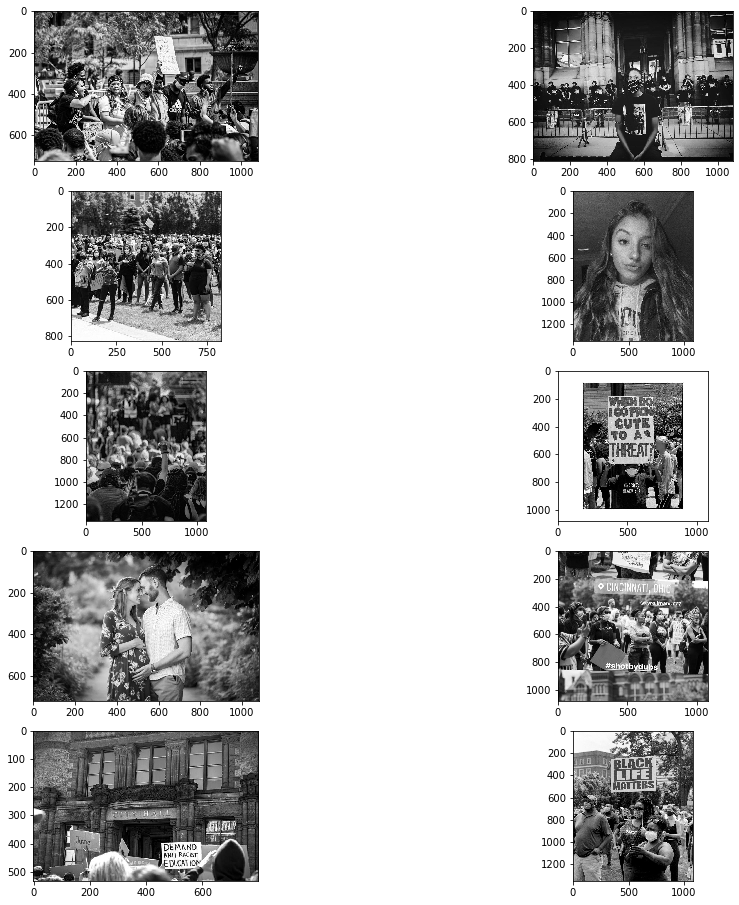

In [17]:
fe = ImageEncoder((8,12,4))
query_image = cv2.imread('65.jpg')
features = fe.extractor(query_image)
searcher = ImageSearch('index.csv')
(results_dis, results) = searcher.search(features, no_of_samples = 10)
#plt.imshow(query_image)
imgs = []
for (score, resultID) in results_dis:
    result = cv2.imread('cleaned_data' + "/" + resultID)
    imgs.append(result)
    
    
    
fig, m_axs = plt.subplots(5,2, figsize = (25, 25))
m_axs = m_axs.flatten()
ind=0
for img, ax in zip(imgs, m_axs):
    ax.imshow(img,cmap=None)
    #ax.set_title(df.iloc[ind]['class'])
    ind=ind+1


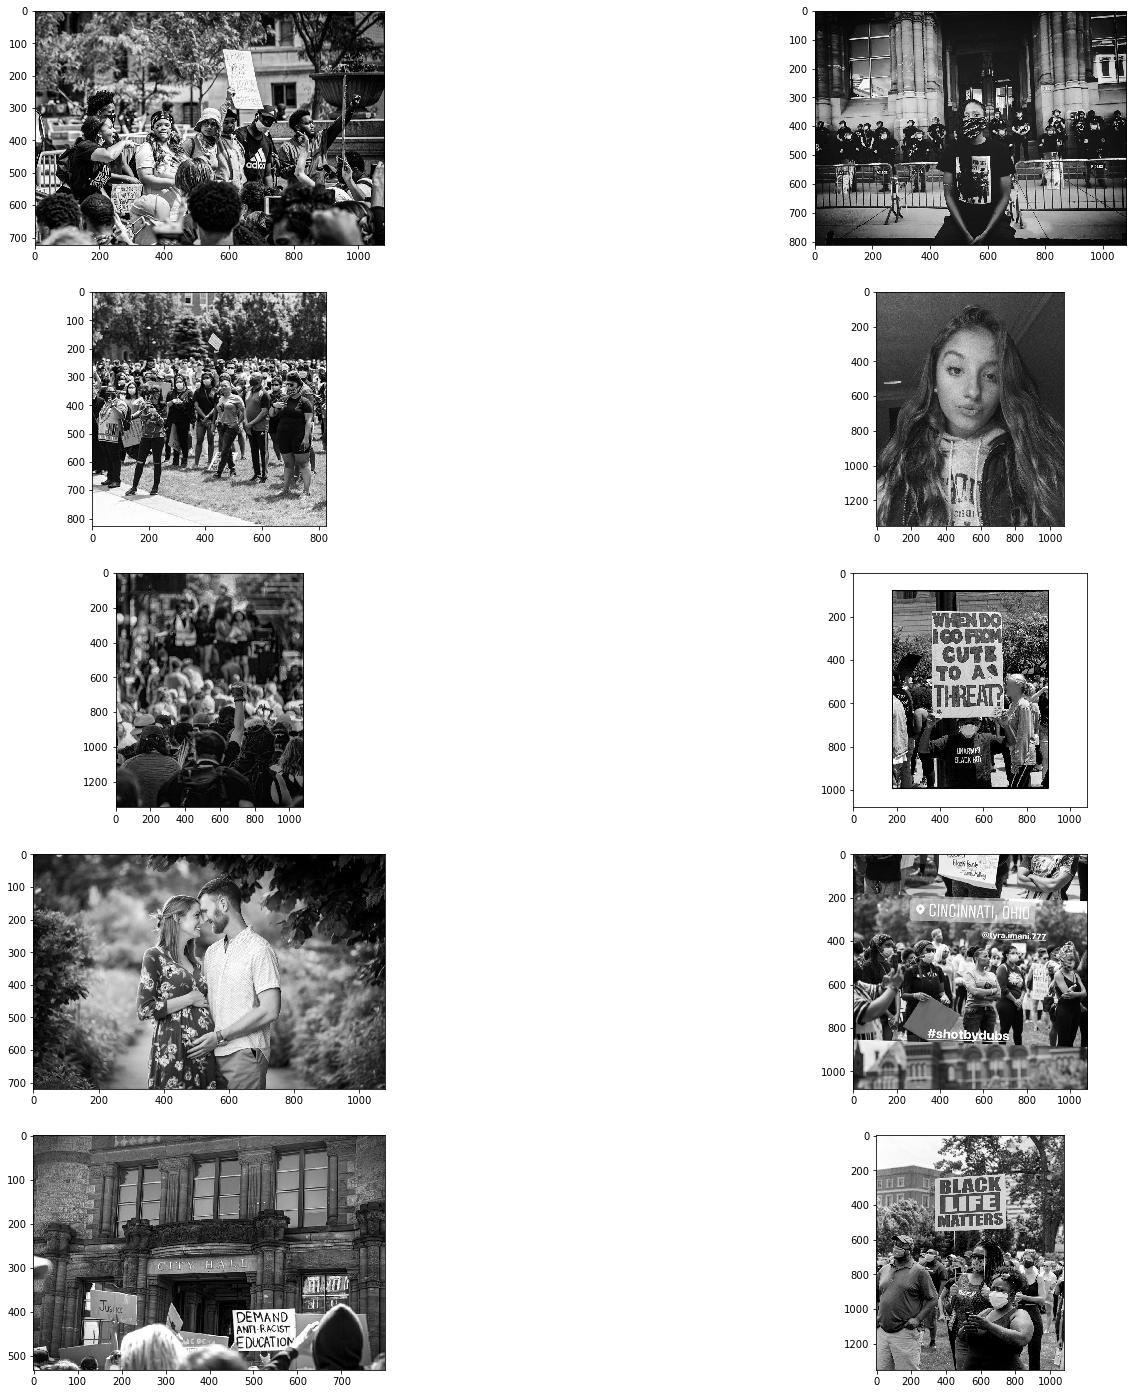

In [18]:
fig, m_axs = plt.subplots(5,2, figsize = (25, 25))
m_axs = m_axs.flatten()
ind=0
for img, ax in zip(imgs, m_axs):
    ax.imshow(img,cmap=None)
    #ax.set_title(df.iloc[ind]['class'])
    ind=ind+1